In [1]:
%load_ext autoreload
%autoreload 2



In [15]:
%reload_ext autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from setdir import *
from plotglider import *
from scipy.io import loadmat # to load bathymetry
import xarray as xr
import seaborn as sns

In [16]:
# Need to update this for reading from a netcdf file
yyyymmdd = '20220118'

# Load both glider datasets
file1 = 'unit_409_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit409 = xr.open_dataset(infile)

file1 = 'unit_398_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit398 = xr.open_dataset(infile)

# Load glider positions
yyyymmdd = '20220119'

file1 = 'unit_409_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit409pos = xr.open_dataset(infile)

file1 = 'unit_398_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit398pos = xr.open_dataset(infile)

# Location for bathymetry file
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
input_bathy_file = cat_proc_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]



ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
http://xarray.pydata.org/en/stable/user-guide/io.html 
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html

In [14]:
infile

'../01-data/02-intermediate/unit_409_20220118_edit.nc'

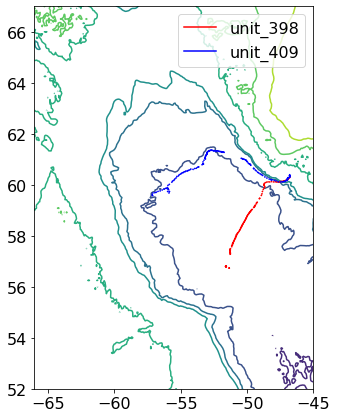

In [10]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks(bathylon,bathylat,bathy,unit409,unit398)

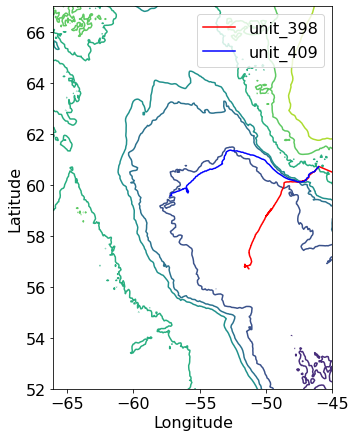

In [8]:
%reload_ext autoreload
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks_pos(bathylon,bathylat,bathy,unit409pos,unit398pos)

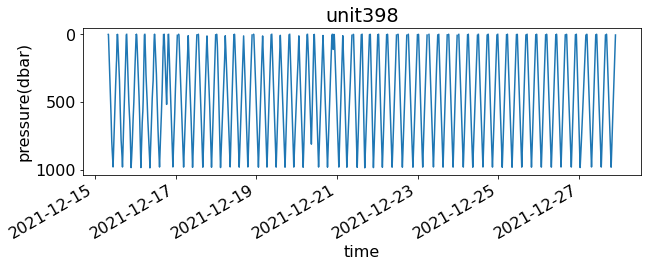

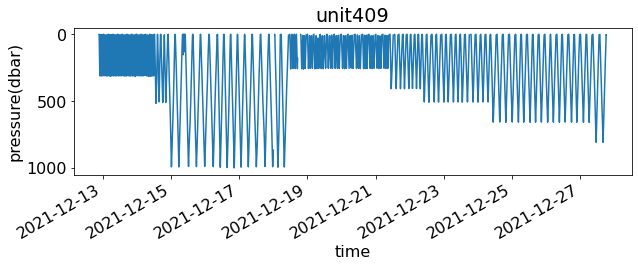

In [20]:
# Plot pressure against time
plot_pressure(unit398,'unit398')

plot_pressure(unit409,'unit409')
# Looks like we are missing shelf data from unit398

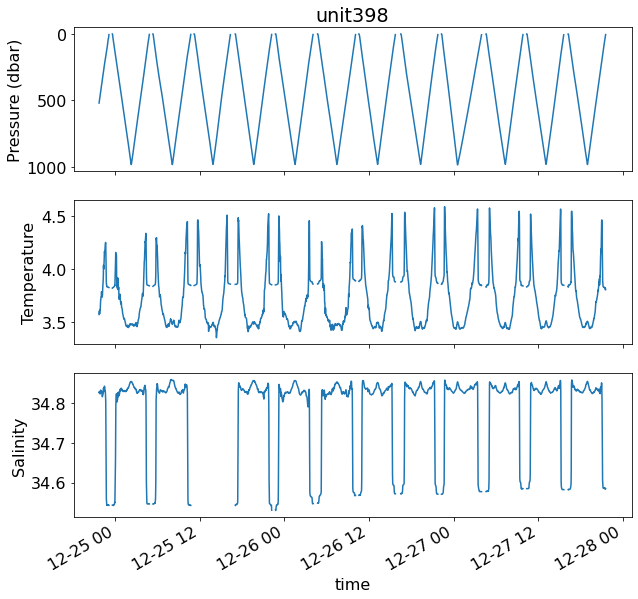

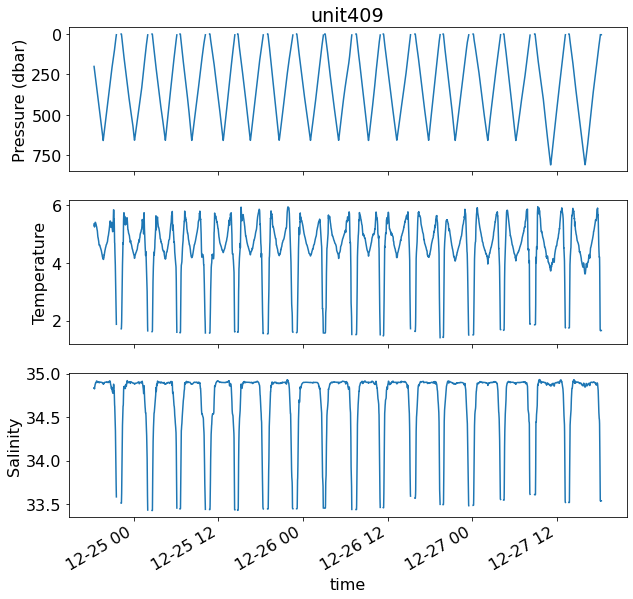

In [22]:
# Plot most recent 3 days
plot_tseries(unit398,3,'unit398')
plot_tseries(unit409,3,'unit409')


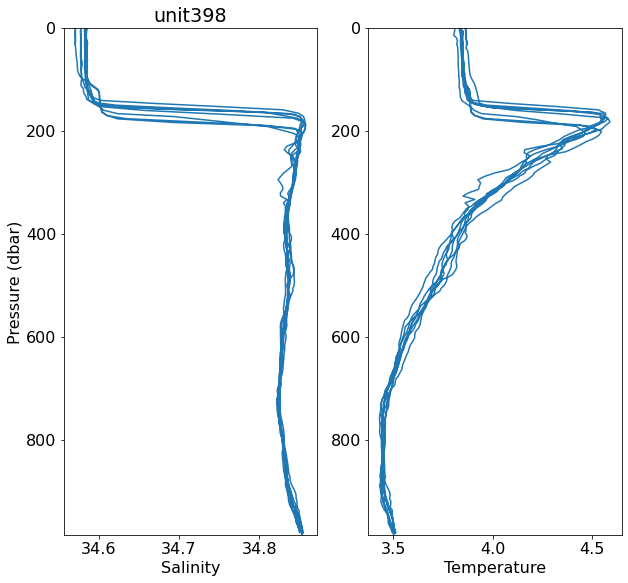

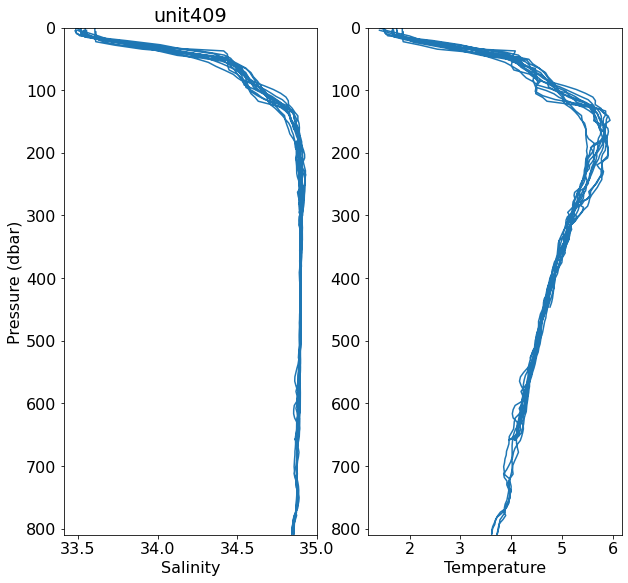

In [23]:
ndays=1
plot_profiles(unit398,ndays,'unit398')
plot_profiles(unit409,ndays,'unit409')
